# Final Proj

#### Initial Scripts

In [1]:
import os
import subprocess
from Bio import AlignIO, SeqIO
from Bio.Align import MultipleSeqAlignment
from itertools import combinations
import pandas as pd
import sys
import matplotlib.pyplot as plt
import time
from itertools import combinations
from collections import defaultdict
import math
import pyhmmer

#### Scoring

In [3]:
def reorder_alignment(reference, test):
    """
    Reorder the test alignment to match the order of the reference alignment by sequence IDs.
    """
    ref_ids = [record.id for record in reference]
    test_dict = {record.id: record for record in test}

    # Ensure all IDs in the reference are present in the test
    if not all(ref_id in test_dict for ref_id in ref_ids):
        missing = [ref_id for ref_id in ref_ids if ref_id not in test_dict]
        print(f"Error: Missing sequences in test alignment: {', '.join(missing)}")
        sys.exit(1)

    # Reorder test alignment to match reference
    reordered_test = MultipleSeqAlignment([test_dict[ref_id] for ref_id in ref_ids])
    return reordered_test

def calculate_sp_score(reference, test):
    """
    Calculate Sum-of-Pairs (SP) score for a test alignment given a reference alignment.
    """
    sp_matches = 0
    total_pairs = 0

    # Use the minimum number of columns to avoid out-of-range errors
    num_columns = min(reference.get_alignment_length(), test.get_alignment_length())

    for col in range(num_columns):
        ref_col = [seq[col] for seq in reference]
        test_col = [seq[col] for seq in test]

        # Generate all pairwise combinations for this column
        ref_pairs = set(combinations(ref_col, 2))
        test_pairs = set(combinations(test_col, 2))

        # Count matching pairs
        sp_matches += len(ref_pairs & test_pairs)
        total_pairs += len(ref_pairs)

    sp_score = sp_matches / total_pairs if total_pairs > 0 else 0
    return sp_score

def calculate_tc_score(reference, test):
    """
    Calculate Total Column (TC) score for a test alignment given a reference alignment.
    """
    column_matches = 0

    # Use the minimum number of columns to avoid out-of-range errors
    num_columns = min(reference.get_alignment_length(), test.get_alignment_length())

    for col in range(num_columns):
        ref_col = [seq[col] for seq in reference]
        test_col = [seq[col] for seq in test]

        if ref_col == test_col:
            column_matches += 1

    tc_score = column_matches / num_columns if num_columns > 0 else 0
    return tc_score

def score_files(ref_file, test_file, format):
    # Load the alignments
    reference = AlignIO.read(ref_file, "msf")
    test = AlignIO.read(test_file, format)

    # Ensure the alignments are loaded as MultipleSeqAlignment objects
    if not isinstance(reference, MultipleSeqAlignment) or not isinstance(test, MultipleSeqAlignment):
        print("Error: Failed to parse the alignments as MultipleSeqAlignment objects.")
        sys.exit(1)

    # Reorder the test alignment to match the reference
    reordered_test = reorder_alignment(reference, test)

    # Calculate scores
    sp_score = calculate_sp_score(reference, reordered_test)
    tc_score = calculate_tc_score(reference, reordered_test)

    # Output results
    return {"SP": sp_score, "TC": tc_score}

# Function to run bali_score
def run_bali_score(reference_msf, test_alignment, score_output):
    print(reference_msf)
    score = score_files(reference_msf, test_alignment, "fasta")
    print(score)
    with open(score_output, 'w') as f_out:
        f_out.write(str(score))
    return score

#### Benchmarks

In [ ]:
# Define the base directory for your files
file_path = 'bb3_release/RV11'

# List all files with .tfa extension and remove the extension
test_cases = [os.path.splitext(file)[0] for file in os.listdir(file_path) if file.endswith('.tfa')]

# Alignment tools with direct command-line calls
alignment_tools = {
    'mafft': {
        'command': lambda input_file, output_file: f"mafft --auto --inputorder {input_file} > {output_file}",
        'output_ext': '_mafft_aligned.fasta'
    },
    'muscle': {
        'command': lambda input_file, output_file: f"muscle -in {input_file} -out {output_file}",
        'output_ext': '_muscle_aligned.fasta'
    },
    'clustalw': {
        'command': lambda input_file, output_file: f"clustalw -INFILE={input_file} -OUTFILE={output_file} -OUTPUT=FASTA",
        'output_ext': '_clustalw_aligned.fasta'
    }
}

def get_original_ids(tfa_file):
    original_ids = []
    for record in SeqIO.parse(tfa_file, 'fasta'):
        original_ids.append(record.id)
    return original_ids

def sort_alignment(input_alignment_file, output_alignment_file, file_format, original_ids):
    # Read the alignment
    alignment = AlignIO.read(input_alignment_file, file_format)

    # Create a dictionary of records with IDs as keys
    record_dict = {record.id: record for record in alignment}

    # Reorder the records based on original IDs
    sorted_records = []
    for oid in original_ids:
        if oid in record_dict:
            record = record_dict[oid]
            # Ensure the record ID matches the original ID exactly
            record.id = oid
            sorted_records.append(record)
        else:
            print(f"Warning: ID {oid} not found in alignment.")
            return None  # Alignment IDs don't match

    # Create a new MultipleSeqAlignment object
    sorted_alignment = MultipleSeqAlignment(sorted_records)

    # Write the sorted alignment to a file
    AlignIO.write(sorted_alignment, output_alignment_file, file_format)

    return sorted_alignment

#### PHMM Implementation

In [15]:
class ProfileHMM:
    def __init__(self, pseudocount=0.1):
        """
        Initialize the Profile HMM.
        """
        self.pseudocount = pseudocount
        self.M = 0  # Number of match states
        self.alphabet = []  # Character set from sequences
        self.match_emission = []  # Match state emissions
        self.insert_emission = []  # Insert state emissions
        self.transitions = {}  # Transition probabilities

    def train(self, aligned_sequences):
        """
        Train the profile HMM using a given MSA.
        """
        if not aligned_sequences:
            raise ValueError("No sequences provided for training.")

        seqs = list(aligned_sequences.values())
        self.M = len(seqs[0])  # Length of alignment
        self.alphabet = list({char for seq in seqs for char in seq if char != '-'})

        # Count emissions and transitions
        match_counts = [defaultdict(int) for _ in range(self.M)]
        transition_counts = defaultdict(lambda: defaultdict(int))


        for seq in seqs:
            prev_state = ('S', 0)  # Start state
            for i, char in enumerate(seq, start=1):
                if char == '-':
                    transition_counts[prev_state][('D', i)] += 1
                    prev_state = ('D', i)
                else:
                    transition_counts[prev_state][('M', i)] += 1
                    match_counts[i - 1][char] += 1
                    prev_state = ('M', i)
            transition_counts[prev_state][('E', 0)] += 1  # End state

        # Calculate emissions
        self.match_emission = [
            {a: (match_counts[i].get(a, 0) + self.pseudocount) /
                (sum(match_counts[i].values()) + len(self.alphabet) * self.pseudocount)
             for a in self.alphabet}
            for i in range(self.M)
        ]

        self.insert_emission = [
            {a: self.pseudocount / (len(self.alphabet) * self.pseudocount)
             for a in self.alphabet}
            for _ in range(self.M + 1)
        ]

        # Normalize transitions
        self.transitions = {
            prev: {nxt: (count + self.pseudocount) /
                   (sum(next_counts.values()) + len(next_counts) * self.pseudocount)
                   for nxt, count in next_counts.items()}
            for prev, next_counts in transition_counts.items()
        }

    def viterbi_align(self, sequence):
        """
        Align a sequence to the profile HMM using the Viterbi algorithm.
        """
        n = len(sequence)
        state_list = [('S', 0), ('I', 0)] + \
                     [(t, i) for i in range(1, self.M + 1) for t in ('M', 'I', 'D')] + \
                     [('E', 0)]
        state_index = {s: idx for idx, s in enumerate(state_list)}

        v = [[-math.inf] * (n + 1) for _ in range(len(state_list))]
        traceback = [[None] * (n + 1) for _ in range(len(state_list))]

        v[state_index[('S', 0)]][0] = 0.0

        def emission_prob(state, char):
            stype, idx = state
            if stype == 'M':
                return math.log(self.match_emission[idx - 1].get(char, self.pseudocount))
            if stype == 'I':
                return math.log(self.insert_emission[idx].get(char, self.pseudocount))
            return 0.0

        for j in range(n + 1):
            for i, state in enumerate(state_list):
                if v[i][j] == -math.inf:
                    continue
                curr_score = v[i][j]
                for nxt_state, tprob in self.transitions.get(state, {}).items():
                    nxt_i = state_index[nxt_state]
                    if nxt_state[0] in {'M', 'I'} and j < n:
                        char = sequence[j]
                        score = curr_score + math.log(tprob) + emission_prob(nxt_state, char)
                        if score > v[nxt_i][j + 1]:
                            v[nxt_i][j + 1] = score
                            traceback[nxt_i][j + 1] = (i, j)
                    elif nxt_state[0] in {'D', 'E'}:
                        score = curr_score + math.log(tprob)
                        if score > v[nxt_i][j]:
                            v[nxt_i][j] = score
                            traceback[nxt_i][j] = (i, j)

        aligned_seq = []
        best_score = v[state_index[('E', 0)]][n]
        if best_score == -math.inf:
            return '-' * n

        ci, cj = state_index[('E', 0)], n
        while ci != state_index[('S', 0)] or cj != 0:
            state, jpos = state_list[ci], cj
            if state[0] in {'M', 'I'}:
                aligned_seq.append(sequence[jpos - 1])
            elif state[0] == 'D':
                aligned_seq.append('-')
            ci, cj = traceback[ci][cj]

        return ''.join(reversed(aligned_seq))

    def align_sequences(self, sequences, output_file=None):
        """
        Align multiple sequences to the profile HMM.
        """
        aligned_records = [
            (name, self.viterbi_align(seq)) for name, seq in sequences.items()
        ]
        if output_file:
            with open(output_file, "w") as f:
                for name, aligned_seq in aligned_records:
                    f.write(f">{name}\n{aligned_seq}\n")
        return aligned_records


#### Comparison

In [6]:
def convert_msf_to_fasta(input_msf, output_fasta):
    """
    Convert an MSF alignment file to FASTA format.

    Args:
        input_msf (str): Path to the input MSF file.
        output_fasta (str): Path to the output FASTA file.
    """
    try:
        # Read the MSF file
        alignment = AlignIO.read(input_msf, "msf")
        
        # Write to FASTA format
        AlignIO.write(alignment, output_fasta, "fasta")
        print(f"Conversion successful: '{input_msf}' -> '{output_fasta}'")
    except Exception as e:
        print(f"Error during conversion: {e}")

# Build HMM using pyHMMER
def build_pyhmmer_hmm(fasta_file, hmm_name):
    alphabet = pyhmmer.easel.Alphabet.amino()
    background = pyhmmer.plan7.Background(alphabet)

    with pyhmmer.easel.MSAFile(fasta_file, digital=True, alphabet=alphabet) as msa_file:
        msa = msa_file.read()
        msa.name = hmm_name.encode()
        builder = pyhmmer.plan7.Builder(alphabet)
        hmm, _, _ = builder.build_msa(msa, background)

    with open("profile.hmm", "wb") as hmm_file:
        hmm.write(hmm_file)
    
    return hmm, alphabet, background

# Align sequences using your ProfileHMM
def align_with_profilehmm(profilehmm: ProfileHMM, test_sequences_file, output_file):
    test_alignment = SeqIO.parse(test_sequences_file, "fasta")
    sequences = {record.id: "".join(str(record.seq)) for record in test_alignment}
    aligned_sequences = profilehmm.align_sequences(sequences, output_file)
    
    return aligned_sequences

def align_with_hmmalign(hmm_file, input_fasta, stockholm_output, fasta_output):
    """
    Align sequences to an HMM using hmmalign and convert Stockholm to FASTA.
    Args:
        hmm_file (str): Path to the HMM file.
        input_fasta (str): Path to the unaligned FASTA file.
        stockholm_output (str): Path to save the Stockholm alignment.
        fasta_output (str): Path to save the FASTA alignment.
    """
    try:
        # Run hmmalign
        print("Running hmmalign...")
        subprocess.run(
            ["hmmalign", "--amino", "-o", stockholm_output, hmm_file, input_fasta],
            check=True
        )
        print(f"Stockholm alignment saved to '{stockholm_output}'")

        # Convert Stockholm to FASTA
        print("Converting Stockholm to FASTA...")
        alignment = AlignIO.read(stockholm_output, "stockholm")
        AlignIO.write(alignment, fasta_output, "fasta")
        print(f"FASTA alignment saved to '{fasta_output}'")
    except subprocess.CalledProcessError as e:
        print(f"Error during hmmalign: {e}")
    except Exception as e:
        print(f"Error during conversion to FASTA: {e}")

def convert_to_uppercase(input_fasta, output_fasta):
    """
    Convert all sequences in a FASTA file to uppercase.
    """
    records = []
    for record in SeqIO.parse(input_fasta, "fasta"):
        record.seq = record.seq.upper()
        records.append(record)
    
    SeqIO.write(records, output_fasta, "fasta")
    print(f"Converted sequences written to {output_fasta}")



In [7]:
def train_pHMM(reference_msf):
    # Load reference alignment in MSF format
    reference_alignment = AlignIO.read(reference_msf, "msf")

    # Convert to list of aligned sequences for training
    aligned_sequences = {record.id: "".join(str(record.seq)) for record in reference_alignment}

    # Train your HMM
    hmm = ProfileHMM(pseudocount=.1)
    hmm.train(aligned_sequences)
    return hmm

#### Leave-One-Out Cross Validation

In [38]:
def adjust_alignment_length(hmmer_alignment, reference_alignment):
    """
    Adjust the HMMER alignment to match the length of the reference alignment by truncating or padding.
    Args:
        hmmer_alignment (MultipleSeqAlignment): The alignment output from HMMER.
        reference_alignment (MultipleSeqAlignment): The reference alignment.
    Returns:
        MultipleSeqAlignment: Adjusted HMMER alignment.
    """
    ref_length = reference_alignment.get_alignment_length()
    adjusted_records = []

    for record in hmmer_alignment:
        seq = str(record.seq)
        
        # If the sequence is shorter, pad with gaps
        if len(seq) < ref_length:
            seq += "-" * (ref_length - len(seq))
        
        # If the sequence is longer, truncate to the reference length
        elif len(seq) > ref_length:
            seq = seq[:ref_length]
        
        # Create a new SeqRecord with the adjusted sequence
        adjusted_records.append(SeqRecord(Seq(seq), id=record.id))

    # Return a new MultipleSeqAlignment object with adjusted sequences
    return MultipleSeqAlignment(adjusted_records)

def calculate_LOOCV_sp_score(reference, test, test_id):
    """
    Calculate Sum-of-Pairs (SP) score for a test alignment given a reference alignment.
    Only considers pairs involving the test sequence (identified by test_id).
    Args:
        reference (MultipleSeqAlignment): Full reference alignment.
        test (MultipleSeqAlignment): Predicted alignment containing the test sequence.
        test_id (str): ID of the test sequence.
    Returns:
        float: SP score.
    """
    sp_matches = 0
    total_pairs = 0

    # Ensure test alignment contains the test_id
    test_seq = next((rec for rec in test if rec.id == test_id), None)
    if test_seq is None:
        raise ValueError(f"Test alignment does not include the test sequence {test_id}.")

    # Use the minimum number of columns to avoid out-of-range errors
    num_columns = min(reference.get_alignment_length(), test.get_alignment_length())

    for col in range(num_columns):
        ref_col = [seq[col] for seq in reference]
        test_col = [seq[col] for seq in test]

        # Find the index of the test sequence in the test alignment
        test_idx = [rec.id for rec in test].index(test_id)
        test_residue = test_col[test_idx]

        # Generate all pairwise combinations for this column that involve the test residue
        ref_pairs = set((test_residue, ref_col[i]) for i in range(len(ref_col)))
        test_pairs = set((test_residue, test_col[i]) for i in range(len(test_col)))

        # Count matching pairs involving the test residue
        sp_matches += len(ref_pairs & test_pairs)
        total_pairs += len(ref_pairs)

    sp_score = sp_matches / total_pairs if total_pairs > 0 else 0
    return sp_score

def calculate_LOOCV_tc_score(reference, test, test_id):
    """
    Calculate Total Column (TC) score for a test alignment given a reference alignment.
    Only considers columns involving the test sequence (identified by test_id).
    Args:
        reference (MultipleSeqAlignment): Full reference alignment.
        test (MultipleSeqAlignment): Predicted alignment containing the test sequence.
        test_id (str): ID of the test sequence.
    Returns:
        float: TC score.
    """
    column_matches = 0

    # Ensure test alignment contains the test_id
    test_seq = next((rec for rec in test if rec.id == test_id), None)
    if test_seq is None:
        raise ValueError(f"Test alignment does not include the test sequence {test_id}.")

    # Use the minimum number of columns to avoid out-of-range errors
    num_columns = min(reference.get_alignment_length(), test.get_alignment_length())

    for col in range(num_columns):
        ref_col = [seq[col] for seq in reference]
        test_col = [seq[col] for seq in test]

        # Check if the entire column matches (including the test sequence)
        if ref_col == test_col:
            column_matches += 1

    tc_score = column_matches / num_columns if num_columns > 0 else 0
    return tc_score

In [41]:
def leave_one_out_cross_validation(reference_msf, test_tfa, format="fasta"):
    """
    Perform Leave-One-Out Cross Validation (LOOCV) and compute scores for ProfileHMM and pyHMMER.
    Args:
        reference_msf (str): Path to the reference alignment in MSF format.
        test_tfa (str): Path to the unaligned sequence file (test input).
        format (str): The format to use for the alignment (default is 'fasta').
    Returns:
        dict: Average SP and TC scores for ProfileHMM and pyHMMER.
    """
    # Load the reference alignment
    reference_alignment = AlignIO.read(reference_msf, "msf")
    sequences = {record.id: str(record.seq) for record in reference_alignment}

    # Load unaligned test sequences from .tfa
    test_sequences = {record.id: str(record.seq) for record in SeqIO.parse(test_tfa, "fasta")}

    num_sequences = len(sequences)
    profilehmm_scores = {"SP": [], "TC": []}
    pyhmmer_scores = {"SP": [], "TC": []}

    for left_out_id in sequences.keys():
        print(f"\nPerforming LOOCV: Leaving out sequence {left_out_id}...")

        # Training set: all sequences except the left-out one
        training_set = {seq_id: seq for seq_id, seq in sequences.items() if seq_id != left_out_id}

        # Prepare training alignment in FASTA format for pyHMMER
        training_fasta = "training_set.fasta"
        with open(training_fasta, "w") as f:
            for seq_id, seq in training_set.items():
                f.write(f">{seq_id}\n{seq}\n")

        # Train ProfileHMM
        profilehmm = ProfileHMM()
        profilehmm.train(training_set)

        # Align the test sequence using ProfileHMM
        if left_out_id not in test_sequences:
            print(f"Error: Test sequence {left_out_id} not found in {test_tfa}")
            continue
        test_sequence = test_sequences[left_out_id]
        aligned_profilehmm = profilehmm.align_sequences(
            sequences={left_out_id: test_sequence}, output_file="profilehmm_alignment.fasta"
        )

        # Create a combined alignment with the predicted sequence
        profilehmm_test_alignment = MultipleSeqAlignment(
            [SeqRecord(Seq(aligned_profilehmm[0][1]), id=left_out_id)]
        )
        full_profilehmm_alignment = reference_alignment[:]
        # print(full_profilehmm_alignment.get_alignment_length(), profilehmm_test_alignment.get_alignment_length())
        padded_profilehmm_alignment = adjust_alignment_length(profilehmm_test_alignment, reference_alignment)
        full_profilehmm_alignment.append(padded_profilehmm_alignment[0])

        # Reorder alignment to match reference
        reordered_profilehmm = reorder_alignment(reference_alignment, full_profilehmm_alignment)

        # Score ProfileHMM alignment
        profilehmm_sp = calculate_LOOCV_sp_score(reference_alignment, reordered_profilehmm, left_out_id)
        profilehmm_tc = calculate_LOOCV_tc_score(reference_alignment, reordered_profilehmm, left_out_id)
        profilehmm_scores["SP"].append(profilehmm_sp)
        profilehmm_scores["TC"].append(profilehmm_tc)

        # Train pyHMMER HMM
        hmm, alphabet, background = build_pyhmmer_hmm(training_fasta, "training")

        # Align the test sequence using pyHMMER
        with open("temp_test.fasta", "w") as f:
            f.write(f">{left_out_id}\n{test_sequence}\n")
        stockholm_output = "pyhmmer_alignment.sto"
        fasta_output_pre = "pyhmmer_alignment_pre.fasta"
        fasta_output = "pyhmmer_alignment.fasta"
        align_with_hmmalign("profile.hmm", "temp_test.fasta", stockholm_output, fasta_output_pre)
        convert_to_uppercase(fasta_output_pre, fasta_output)
        # Read the alignment from pyHMMER
        pyhmmer_test_alignment = AlignIO.read(fasta_output, format)
        # print(f"Reference alignment length: {reference_alignment.get_alignment_length()}")
        # print(f"Training set alignment length: {len(training_set[list(training_set.keys())[0]])}")
        # print(f"pyHMMER alignment length: {pyhmmer_test_alignment.get_alignment_length()}")
        full_pyhmmer_alignment = reference_alignment[:]
        padded_pyhmmer_alignment = adjust_alignment_length(pyhmmer_test_alignment, reference_alignment)
        # print(full_pyhmmer_alignment.get_alignment_length(), pyhmmer_test_alignment.get_alignment_length())
        
        full_pyhmmer_alignment.append(padded_pyhmmer_alignment[0])

        # Reorder alignment to match reference
        reordered_pyhmmer = reorder_alignment(reference_alignment, full_pyhmmer_alignment)

        # Score pyHMMER alignment
        pyhmmer_sp = calculate_LOOCV_sp_score(reference_alignment, reordered_pyhmmer, left_out_id)
        pyhmmer_tc = calculate_LOOCV_tc_score(reference_alignment, reordered_pyhmmer, left_out_id)
        pyhmmer_scores["SP"].append(pyhmmer_sp)
        pyhmmer_scores["TC"].append(pyhmmer_tc)

    # Calculate average scores
    avg_profilehmm_sp = sum(profilehmm_scores["SP"]) / num_sequences
    avg_profilehmm_tc = sum(profilehmm_scores["TC"]) / num_sequences
    avg_pyhmmer_sp = sum(pyhmmer_scores["SP"]) / num_sequences
    avg_pyhmmer_tc = sum(pyhmmer_scores["TC"]) / num_sequences

    return {
        "ProfileHMM": {"SP": avg_profilehmm_sp, "TC": avg_profilehmm_tc},
        "pyHMMER": {"SP": avg_pyhmmer_sp, "TC": avg_pyhmmer_tc},
    }

In [42]:
# Example Usage
base_dir = "bb3_release/RV11"
reference_msf = os.path.join(base_dir, "BB11001.msf")
unaligned_fasta = os.path.join(base_dir, "BB11001.tfa")
scores = leave_one_out_cross_validation(reference_msf, unaligned_fasta)

print("\nLOOCV Results:")
print(f"ProfileHMM: SP={scores['ProfileHMM']['SP']:.3f}, TC={scores['ProfileHMM']['TC']:.3f}")
print(f"pyHMMER: SP={scores['pyHMMER']['SP']:.3f}, TC={scores['pyHMMER']['TC']:.3f}")


Performing LOOCV: Leaving out sequence 1j46_A...
Running hmmalign...
Stockholm alignment saved to 'pyhmmer_alignment.sto'
Converting Stockholm to FASTA...
FASTA alignment saved to 'pyhmmer_alignment_pre.fasta'
Converted sequences written to pyhmmer_alignment.fasta

Performing LOOCV: Leaving out sequence 2lef_A...
Running hmmalign...
Stockholm alignment saved to 'pyhmmer_alignment.sto'
Converting Stockholm to FASTA...
FASTA alignment saved to 'pyhmmer_alignment_pre.fasta'
Converted sequences written to pyhmmer_alignment.fasta

Performing LOOCV: Leaving out sequence 1k99_A...
Running hmmalign...
Stockholm alignment saved to 'pyhmmer_alignment.sto'
Converting Stockholm to FASTA...
FASTA alignment saved to 'pyhmmer_alignment_pre.fasta'
Converted sequences written to pyhmmer_alignment.fasta

Performing LOOCV: Leaving out sequence 1aab_...
Running hmmalign...
Stockholm alignment saved to 'pyhmmer_alignment.sto'
Converting Stockholm to FASTA...
FASTA alignment saved to 'pyhmmer_alignment_pre

In [ ]:
# Define the base directory for your files
file_path = 'bb3_release/RV11'
hmm_file = f"profile.hmm"
# List all files with .tfa extension and remove the extension
test_cases = [os.path.splitext(file)[0] for file in os.listdir(file_path) if file.endswith('.tfa')]

results = []

for test_case in test_cases:
    print(f"Processing {test_case}...")
    tfa_file = os.path.join(file_path, f'{test_case}.tfa')
    msf_file = os.path.join(file_path, f'{test_case}.msf')
    fasta_file = os.path.join(file_path, f'{test_case}.fasta')
    
    if not os.path.exists(fasta_file):
        print(f'Converting {msf_file} to FASTA format...')
        convert_msf_to_fasta(msf_file, fasta_file)
    
    # Check if files exist
    if not os.path.exists(tfa_file) or not os.path.exists(fasta_file):
        print(f'Files for {test_case} not found.')
        continue
    
    case_results = leave_one_out_cross_validation(msf_file, tfa_file, format="fasta")
    
    results.append({
        'test_case': test_case,
        'ProfileHMM_SP': case_results['ProfileHMM']['SP'],
        'pyHMMER_SP': case_results['pyHMMER']['SP'],
        'ProfileHMM_TC': case_results['ProfileHMM']['TC'],
        'pyHMMER_TC': case_results['pyHMMER']['TC']
    })

df = pd.DataFrame(results)


Performing LOOCV: Leaving out sequence 1gow_A...
Running hmmalign...
Stockholm alignment saved to 'pyhmmer_alignment.sto'
Converting Stockholm to FASTA...
FASTA alignment saved to 'pyhmmer_alignment_pre.fasta'
Converted sequences written to pyhmmer_alignment.fasta

Performing LOOCV: Leaving out sequence 1vjz_A...
Running hmmalign...
Stockholm alignment saved to 'pyhmmer_alignment.sto'
Converting Stockholm to FASTA...
FASTA alignment saved to 'pyhmmer_alignment_pre.fasta'
Converted sequences written to pyhmmer_alignment.fasta

Performing LOOCV: Leaving out sequence 1bqc_A...
Running hmmalign...
Stockholm alignment saved to 'pyhmmer_alignment.sto'
Converting Stockholm to FASTA...
FASTA alignment saved to 'pyhmmer_alignment_pre.fasta'
Converted sequences written to pyhmmer_alignment.fasta

Performing LOOCV: Leaving out sequence 1qno_A...
Running hmmalign...
Stockholm alignment saved to 'pyhmmer_alignment.sto'
Converting Stockholm to FASTA...
FASTA alignment saved to 'pyhmmer_alignment_pr

In [44]:
df[['ProfileHMM_SP', 'pyHMMER_SP', 'ProfileHMM_TC', 'pyHMMER_TC']].mean()

ProfileHMM_SP    0.917593
pyHMMER_SP       0.897629
ProfileHMM_TC    0.555103
pyHMMER_TC       0.235172
dtype: float64

## Full LOOCV Comparison, All Methods

In [51]:
def loocv_single_test_case(tfa_file, msf_file, alignment_tool):
    """
    Perform LOOCV for a single test case with a single MSA tool and compute averaged SP and TC scores.
    
    Args:
        tfa_file (str): Path to the unaligned .tfa file for the test case.
        msf_file (str): Path to the reference .msf file for the test case.
        alignment_tool (dict): Dictionary containing the tool's command and output extension.
        
    Returns:
        dict: Averaged SP and TC scores, and runtime for the tool.
    """
    # Load test sequences
    test_sequences = list(SeqIO.parse(tfa_file, "fasta"))
    if not test_sequences:
        raise ValueError("No sequences found in the test case.")

    # Run MSA for the entire test case
    output_file = tfa_file.replace(".tfa", alignment_tool["output_ext"])
    command = alignment_tool["command"](tfa_file, output_file)
    print(f"Running MSA tool: {command}")

    start = time.time()
    process = subprocess.run(command, shell=True, capture_output=True, text=True)
    end = time.time()

    if process.returncode != 0:
        raise RuntimeError(f"Error running MSA tool: {process.stderr}")

    # Load the full MSA alignment
    try:
        msa_alignment = AlignIO.read(output_file, "fasta")
    except Exception as e:
        raise RuntimeError(f"Error reading alignment output: {e}")

    # Perform LOOCV
    sp_scores = []
    tc_scores = []
    for left_out_seq in test_sequences:
        left_out_id = left_out_seq.id

        # Remove the left-out sequence from the full MSA
        filtered_alignment = MultipleSeqAlignment(
            [rec for rec in msa_alignment if rec.id != left_out_id]
        )

        # Get the left-out sequence's aligned version
        left_out_alignment = next((rec for rec in msa_alignment if rec.id == left_out_id), None)
        if left_out_alignment is None:
            print(f"Warning: Left-out sequence {left_out_id} not found in the MSA.")
            continue

        # Insert the left-out sequence back into the filtered alignment
        loocv_alignment = filtered_alignment[:]
        loocv_alignment.append(left_out_alignment)

        reference_alignment = AlignIO.read(msf_file, "msf")
        
        # Compute SP and TC scores
        try:
            sp_scores.append(calculate_LOOCV_sp_score(reference_alignment, loocv_alignment, left_out_id))
            tc_scores.append(calculate_LOOCV_tc_score(reference_alignment, loocv_alignment, left_out_id))
        except Exception as e:
            print(f"Error scoring left-out sequence {left_out_id}: {e}")
            continue

    # Calculate average SP and TC scores
    avg_sp = sum(sp_scores) / len(sp_scores) if sp_scores else 0
    avg_tc = sum(tc_scores) / len(tc_scores) if tc_scores else 0

    return {
        "SP": avg_sp,
        "TC": avg_tc,
    }


In [52]:
# Define the base directory for your files
file_path = 'bb3_release/RV11'

# List all files with .tfa extension and remove the extension
test_cases = [os.path.splitext(file)[0] for file in os.listdir(file_path) if file.endswith('.tfa')]

# Alignment tools with direct command-line calls
alignment_tools = {
    'mafft': {
        'command': lambda input_file, output_file: f"mafft --auto --inputorder {input_file} > {output_file}",
        'output_ext': '_mafft_aligned.fasta'
    },
    'muscle': {
        'command': lambda input_file, output_file: f"muscle -in {input_file} -out {output_file}",
        'output_ext': '_muscle_aligned.fasta'
    },
    'clustalw': {
        'command': lambda input_file, output_file: f"clustalw -INFILE={input_file} -OUTFILE={output_file} -OUTPUT=FASTA",
        'output_ext': '_clustalw_aligned.fasta'
    }
}

def get_original_ids(tfa_file):
    original_ids = []
    for record in SeqIO.parse(tfa_file, 'fasta'):
        original_ids.append(record.id)
    return original_ids

def sort_alignment(input_alignment_file, output_alignment_file, file_format, original_ids):
    # Read the alignment
    alignment = AlignIO.read(input_alignment_file, file_format)

    # Create a dictionary of records with IDs as keys
    record_dict = {record.id: record for record in alignment}

    # Reorder the records based on original IDs
    sorted_records = []
    for oid in original_ids:
        if oid in record_dict:
            record = record_dict[oid]
            # Ensure the record ID matches the original ID exactly
            record.id = oid
            sorted_records.append(record)
        else:
            print(f"Warning: ID {oid} not found in alignment.")
            return None  # Alignment IDs don't match

    # Create a new MultipleSeqAlignment object
    sorted_alignment = MultipleSeqAlignment(sorted_records)

    # Write the sorted alignment to a file
    AlignIO.write(sorted_alignment, output_alignment_file, file_format)

    return sorted_alignment

In [71]:
def run_test_on_set(file_path):
    # Main benchmarking loop
    
    # List all files with .tfa extension and remove the extension
    test_cases = [os.path.splitext(file)[0] for file in os.listdir(file_path) if file.endswith('.tfa')]
    
    if not os.path.exists(f'{file_path}/results'):
        os.makedirs(f'{file_path}/results')
    
    full_msa_results = []
    LOOCV_results = []
    train_test_time = []

    for test_case in test_cases:
        tfa_file = os.path.join(file_path, f'{test_case}.tfa')
        msf_file = os.path.join(file_path, f'{test_case}.msf')
        fasta_file = os.path.join(file_path, f'{test_case}.fasta')
    
        if not os.path.exists(fasta_file):
            print(f'Converting {msf_file} to FASTA format...')
            convert_msf_to_fasta(msf_file, fasta_file)
        # Check if files exist
        if not os.path.exists(tfa_file) or not os.path.exists(msf_file):
            print(f'Files for {test_case} not found.')
            continue
        
        phmm_train_time = time.time()
        phmm = train_pHMM(msf_file)
        phmm_train_time = time.time() - phmm_train_time
        hmmer_train_time = time.time()
        build_pyhmmer_hmm(fasta_file, test_case)
        hmmer_train_time = time.time() - hmmer_train_time
        phmm_test_time = time.time()
        align_with_profilehmm(phmm, tfa_file, f'{file_path}/{test_case}_profilehmm.fasta')
        phmm_test_time = time.time() - phmm_test_time
        hmmer_test_time = time.time()
        align_with_hmmalign(hmm_file, tfa_file, f'{file_path}/{test_case}_hmmer.sto', f'{file_path}/{test_case}_hmmer.fasta')
        hmmer_test_time = time.time() - hmmer_test_time
        convert_to_uppercase(f'{file_path}/{test_case}_hmmer.fasta', f'{file_path}/{test_case}_hmmer.fasta')
        
        train_test_time.append({
            'test_case': test_case,
            'tool': 'ProfileHMM',
            'train_time': phmm_train_time,
            'test_time': phmm_test_time
        })
        train_test_time.append({
            'test_case': test_case,
            'tool': 'HMMER',
            'train_time': hmmer_train_time,
            'test_time': hmmer_test_time
        })
        
        LOOCV_pHMM = leave_one_out_cross_validation(msf_file, tfa_file, format="fasta")
        LOOCV_results.append({
            'test_case': test_case,
            'tool': 'ProfileHMM',
            'SP': LOOCV_pHMM['ProfileHMM']['SP'],
            'TC': LOOCV_pHMM['ProfileHMM']['TC']
        })
        LOOCV_results.append({
            'test_case': test_case,
            'tool': 'HMMER',
            'SP': LOOCV_pHMM['pyHMMER']['SP'],
            'TC': LOOCV_pHMM['pyHMMER']['TC']
        })
        
        for tool_name, tool_info in alignment_tools.items():
            output_file = os.path.join(f'{file_path}/results', f'{test_case}{tool_info["output_ext"]}')
            # sorted_output_file = os.path.join(f'{file_path}/results', f'{test_case}_{tool_name}_sorted.msf')
            score_output = os.path.join(f'{file_path}/results', f'{test_case}_{tool_name}_score.txt')

            print(f'Running {tool_name} on {test_case}...')

            # Construct the command
            command = tool_info['command'](tfa_file, output_file)
            print(f'Executing command: {command}')

            start = time.time()
            # Run the alignment tool
            process = subprocess.run(command, shell=True, capture_output=True, text=True)
            end = time.time()

            # Check for errors
            if process.returncode != 0:
                print(f"Error running {tool_name} on {test_case}:")
                print(process.stderr)
                continue

            # If you want to use MSF instead:
            score = run_bali_score(msf_file, output_file, score_output)
            
            # LOOPCV
            loocv_results = loocv_single_test_case(tfa_file, msf_file, tool_info)
            
            
            # Append to results
            full_msa_results.append({
                'test_case': test_case,
                'tool': tool_name,
                'TC': score['TC'],
                'SP': score['SP'],
                'time': end - start
            })
            
            LOOCV_results.append({
                'test_case': test_case,
                'tool': tool_name,
                'SP': loocv_results['SP'],
                'TC': loocv_results['TC']
            })

            # print(f'Results for {tool_name} on {test_case}:')
            # print(score)
            # print('---')

    # Display results in a DataFrame
    full_msa = pd.DataFrame(full_msa_results)
    loocv = pd.DataFrame(LOOCV_results)
    train_test = pd.DataFrame(train_test_time)
    return full_msa, loocv, train_test
    

In [72]:
full_msa_rv11, loocv_rv11, train_test_times_rv11 = run_test_on_set(file_path)

Running hmmalign...
Stockholm alignment saved to 'bb3_release/RV11/BB11031_hmmer.sto'
Converting Stockholm to FASTA...
FASTA alignment saved to 'bb3_release/RV11/BB11031_hmmer.fasta'
Converted sequences written to bb3_release/RV11/BB11031_hmmer.fasta

Performing LOOCV: Leaving out sequence 1gow_A...
Running hmmalign...
Stockholm alignment saved to 'pyhmmer_alignment.sto'
Converting Stockholm to FASTA...
FASTA alignment saved to 'pyhmmer_alignment_pre.fasta'
Converted sequences written to pyhmmer_alignment.fasta

Performing LOOCV: Leaving out sequence 1vjz_A...
Running hmmalign...
Stockholm alignment saved to 'pyhmmer_alignment.sto'
Converting Stockholm to FASTA...
FASTA alignment saved to 'pyhmmer_alignment_pre.fasta'
Converted sequences written to pyhmmer_alignment.fasta

Performing LOOCV: Leaving out sequence 1bqc_A...
Running hmmalign...
Stockholm alignment saved to 'pyhmmer_alignment.sto'
Converting Stockholm to FASTA...
FASTA alignment saved to 'pyhmmer_alignment_pre.fasta'
Conver

In [76]:
full_msa_rv11[['tool', 'SP', 'TC', 'time']].groupby('tool').mean()

,SP,TC,time
tool,,,
clustalw,0.198547,0.115838,0.114764
mafft,0.176198,0.096358,1.449548
muscle,0.206147,0.121346,0.154526


In [77]:
loocv_rv11[['tool', 'SP', 'TC']].groupby('tool').mean()

,SP,TC
tool,,
HMMER,0.897629,0.235172
ProfileHMM,0.917593,0.555103
clustalw,0.399105,0.022941
mafft,0.367577,0.028430
muscle,0.393840,0.021737


In [79]:
train_test_times_rv11[['tool', 'train_time', 'test_time']].groupby('tool').mean()

,train_time,test_time
tool,,
HMMER,0.094457,0.040067
ProfileHMM,0.010247,0.927607


In [73]:
full_msa_rv12, loocv_rv12, train_test_times_rv12 = run_test_on_set(file_path[:-1] + '2')

Converting bb3_release/RV12/BBS12007.msf to FASTA format...
Conversion successful: 'bb3_release/RV12/BBS12007.msf' -> 'bb3_release/RV12/BBS12007.fasta'
Running hmmalign...
Stockholm alignment saved to 'bb3_release/RV12/BBS12007_hmmer.sto'
Converting Stockholm to FASTA...
FASTA alignment saved to 'bb3_release/RV12/BBS12007_hmmer.fasta'
Converted sequences written to bb3_release/RV12/BBS12007_hmmer.fasta

Performing LOOCV: Leaving out sequence 1bgl_A...
Running hmmalign...
Stockholm alignment saved to 'pyhmmer_alignment.sto'
Converting Stockholm to FASTA...
FASTA alignment saved to 'pyhmmer_alignment_pre.fasta'
Converted sequences written to pyhmmer_alignment.fasta

Performing LOOCV: Leaving out sequence BGAL_THEMA...
Running hmmalign...
Stockholm alignment saved to 'pyhmmer_alignment.sto'
Converting Stockholm to FASTA...
FASTA alignment saved to 'pyhmmer_alignment_pre.fasta'
Converted sequences written to pyhmmer_alignment.fasta

Performing LOOCV: Leaving out sequence BGA2_ECOLI...
Runn

In [66]:
full_msa_rv12[['tool', 'SP', 'TC', 'time']].groupby('tool').mean()

,SP,TC,time
tool,,,
clustalw,0.312584,0.225172,0.222308
mafft,0.269767,0.185861,1.443123
muscle,0.274248,0.208398,0.168433


In [67]:
loocv_rv12[['tool', 'SP', 'TC']].groupby('tool').mean()

,SP,TC
tool,,
HMMER,0.921662,0.207431
ProfileHMM,0.949076,0.665920
clustalw,0.483934,0.044562
mafft,0.437369,0.065093
muscle,0.447359,0.036741


In [80]:
train_test_times_rv12[['tool', 'train_time', 'test_time']].groupby('tool').mean()

,train_time,test_time
tool,,
HMMER,0.129073,0.052460
ProfileHMM,0.011135,1.747854


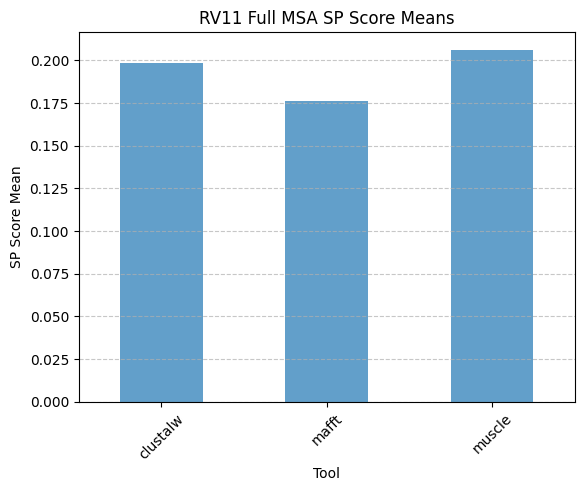

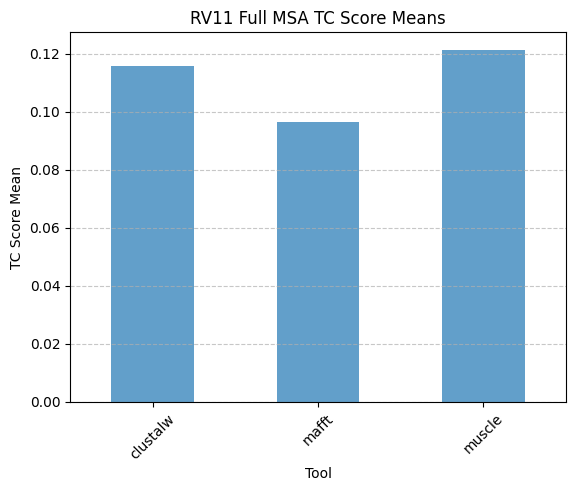

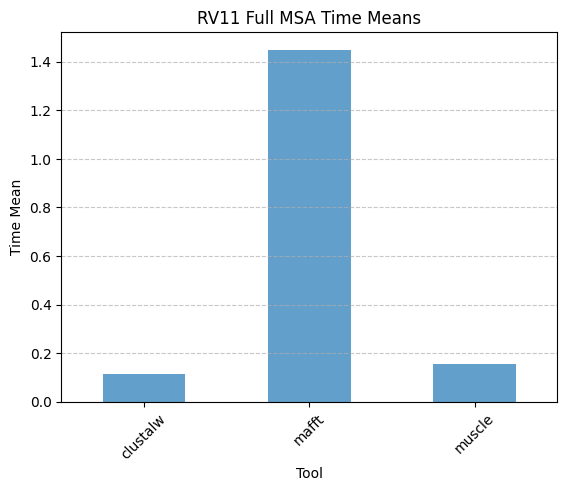

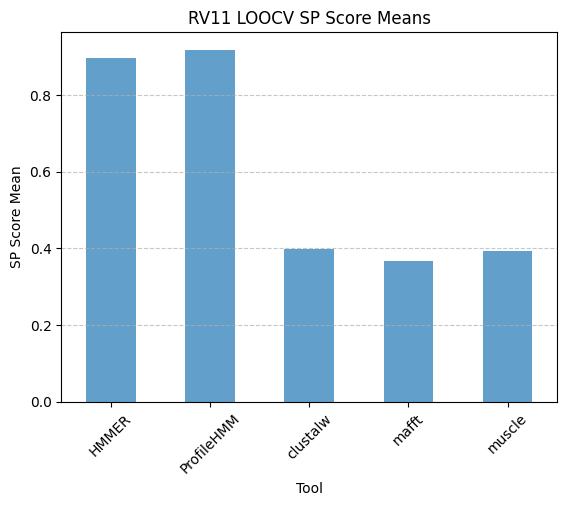

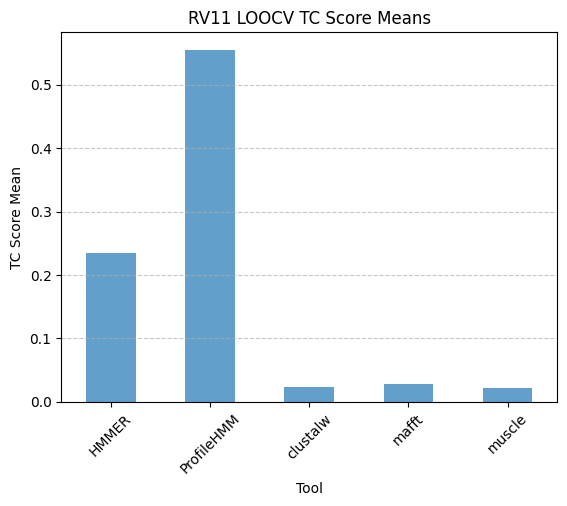

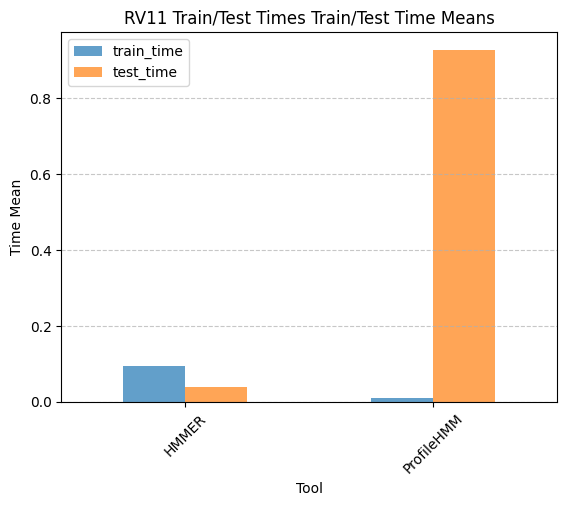

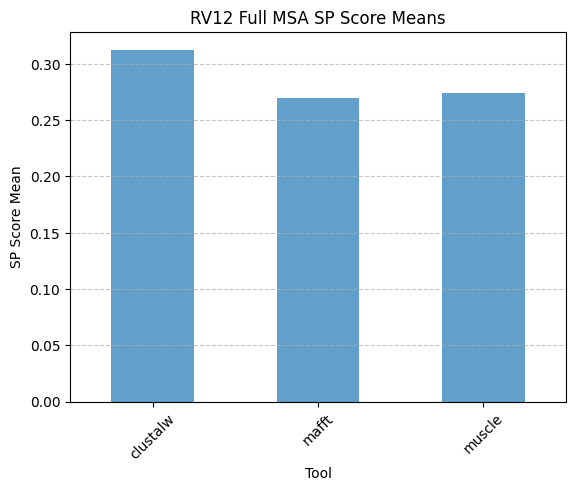

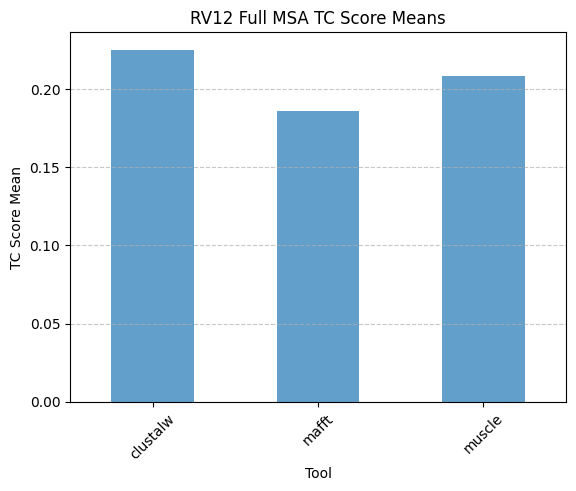

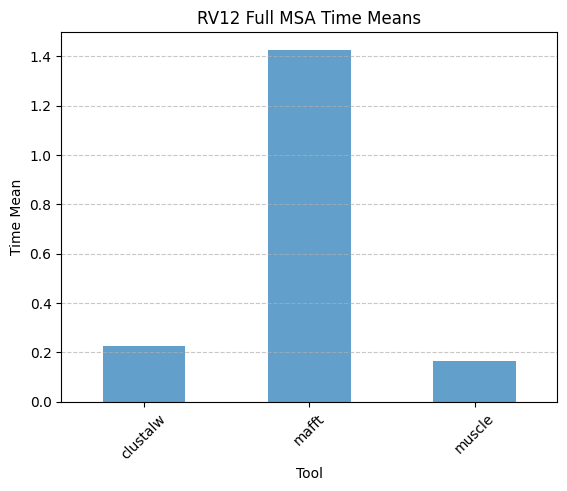

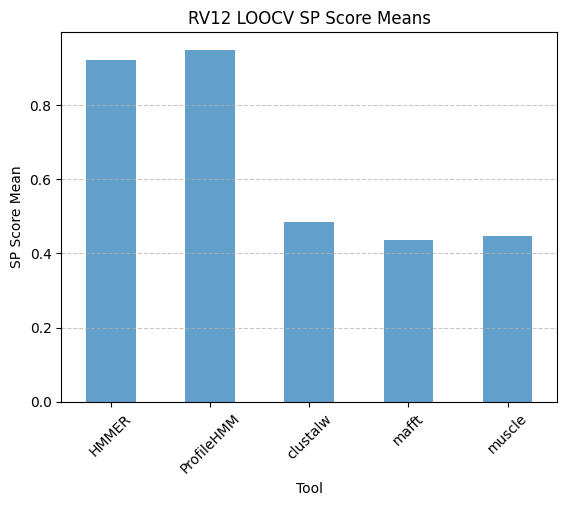

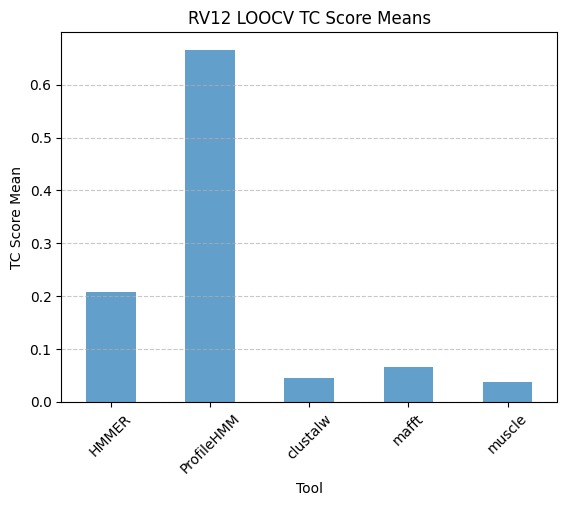

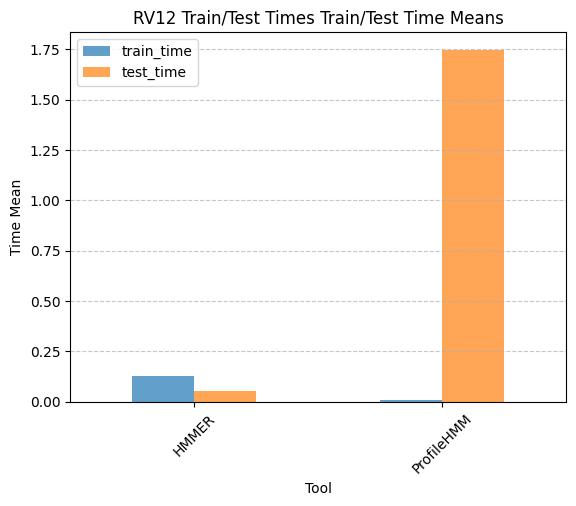

In [ ]:
# Function to plot means for a given dataframe and title
def plot_means(df, title_prefix):
    # Plot means for SP and TC scores
    for column in ['SP', 'TC']:
        plt.figure()
        df[column].plot(kind='bar', alpha=0.7)
        plt.title(f'{title_prefix} {column} Score Means')
        plt.xlabel('Tool')
        plt.ylabel(f'{column} Score Mean')
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

    # Plot means for time if it exists in the dataframe
    if 'time' in df.columns:
        plt.figure()
        df['time'].plot(kind='bar', alpha=0.7)
        plt.title(f'{title_prefix} Time Means')
        plt.xlabel('Tool')
        plt.ylabel('Time Mean')
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

    # Plot means for train_time and test_time if they exist in the dataframe
    if 'train_time' in df.columns and 'test_time' in df.columns:
        plt.figure()
        df[['train_time', 'test_time']].plot(kind='bar', alpha=0.7)
        plt.title(f'{title_prefix} Train/Test Time Means')
        plt.xlabel('Tool')
        plt.ylabel('Time Mean')
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

# Function to plot means for train and test times separately
def plot_train_test_means(df, title_prefix):
    df_means = df.groupby('tool')[['train_time', 'test_time']].mean()
    df_means.plot(kind='bar', alpha=0.7)
    plt.title(f'{title_prefix} Train/Test Time Means')
    plt.xlabel('Tool')
    plt.ylabel('Time Mean')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Plot means for full_msa_rv11
plot_means(full_msa_rv11[['tool', 'SP', 'TC', 'time']].groupby('tool').mean(), 'RV11 Full MSA')

# Plot means for loocv_rv11
plot_means(loocv_rv11[['tool', 'SP', 'TC']].groupby('tool').mean(), 'RV11 LOOCV')

# Plot means for train_test_times_rv11
plot_train_test_means(train_test_times_rv11, 'RV11 Train/Test Times')

# Plot means for full_msa_rv12
plot_means(full_msa_rv12[['tool', 'SP', 'TC', 'time']].groupby('tool').mean(), 'RV12 Full MSA')

# Plot means for loocv_rv12
plot_means(loocv_rv12[['tool', 'SP', 'TC']].groupby('tool').mean(), 'RV12 LOOCV')

# Plot means for train_test_times_rv12
plot_train_test_means(train_test_times_rv12, 'RV12 Train/Test Times')

In [87]:
# Save plots for full_msa_rv11
full_msa_rv11_means = full_msa_rv11[['tool', 'SP', 'TC', 'time']].groupby('tool').mean()
for column in ['SP', 'TC', 'time']:
    plt.figure()
    full_msa_rv11_means[column].plot(kind='bar', alpha=0.7)
    plt.title(f'RV11 Full MSA {column} Score Means')
    plt.xlabel('Tool')
    plt.ylabel(f'{column} Score Mean')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig(f'RV11_Full_MSA_{column}_Score_Means.png')
    plt.close()

# Save plots for loocv_rv11
loocv_rv11_means = loocv_rv11[['tool', 'SP', 'TC']].groupby('tool').mean()
for column in ['SP', 'TC']:
    plt.figure()
    loocv_rv11_means[column].plot(kind='bar', alpha=0.7)
    plt.title(f'RV11 LOOCV {column} Score Means')
    plt.xlabel('Tool')
    plt.ylabel(f'{column} Score Mean')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig(f'RV11_LOOCV_{column}_Score_Means.png')
    plt.close()

# Save plots for train_test_times_rv11
train_test_times_rv11_means = train_test_times_rv11.groupby('tool')[['train_time', 'test_time']].mean()
train_test_times_rv11_means.plot(kind='bar', alpha=0.7)
plt.title('RV11 Train/Test Time Means')
plt.xlabel('Tool')
plt.ylabel('Time Mean')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('RV11_Train_Test_Time_Means.png')
plt.close()

# Save plots for full_msa_rv12
full_msa_rv12_means = full_msa_rv12[['tool', 'SP', 'TC', 'time']].groupby('tool').mean()
for column in ['SP', 'TC', 'time']:
    plt.figure()
    full_msa_rv12_means[column].plot(kind='bar', alpha=0.7)
    plt.title(f'RV12 Full MSA {column} Score Means')
    plt.xlabel('Tool')
    plt.ylabel(f'{column} Score Mean')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig(f'RV12_Full_MSA_{column}_Score_Means.png')
    plt.close()

# Save plots for loocv_rv12
loocv_rv12_means = loocv_rv12[['tool', 'SP', 'TC']].groupby('tool').mean()
for column in ['SP', 'TC']:
    plt.figure()
    loocv_rv12_means[column].plot(kind='bar', alpha=0.7)
    plt.title(f'RV12 LOOCV {column} Score Means')
    plt.xlabel('Tool')
    plt.ylabel(f'{column} Score Mean')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig(f'RV12_LOOCV_{column}_Score_Means.png')
    plt.close()

# Save plots for train_test_times_rv12
train_test_times_rv12_means = train_test_times_rv12.groupby('tool')[['train_time', 'test_time']].mean()
train_test_times_rv12_means.plot(kind='bar', alpha=0.7)
plt.title('RV12 Train/Test Time Means')
plt.xlabel('Tool')
plt.ylabel('Time Mean')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('RV12_Train_Test_Time_Means.png')
plt.close()